### LinkedIn Applied Machine Learning Foundations course
Re-doing the tutorials from the course on Applied Machine Learning: Foundations. [link to course](https://www.linkedin.com/learning/applied-machine-learning-foundations)

In this notebook, I build a predictive model to determine if the passengers onboard the titanic survived or not based on details such as age, family, ticket class etc. The analysis is divided into the following sections:

* Exploratory data analysis
    - Looking at distributions of data and trying to see if there are any obvious correlations between features and between features and target
    - Cleaning data: Tackling missing values in appropriate ways, e.g., replacing them by mean if they are not systematically missing (age), or encoding the missingness as a feature itself if it is predictive of survival (deck_present)
    - Visualization using catplots
    - Checking class (im)balanced-ness. A random classifier should get ~62% accuracy on average
    
* Building a predictive model
    - Used a simple Random Forest Classifier
    - Did hyperparameter tuning using cross validation to select parameters
    - Evaluate parameters on test dataset

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#### Chapter 2: Exploratory data analysis and data cleaning
* Use built-in pandas methods
* Use seaborn features



##### Exploring continuous features:

* Look at basic correlations between continuous features and survival probability
* Remove NaN values

In [123]:
df = pd.read_csv('titanic.csv')
df.drop(['Unnamed: 15'], axis=1,inplace=True);
df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [124]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


##### Check class balanced-ness
This is the most important thing in any exploration of the data (something they missed in the course). We want to check what percentage of the total dataset is true (survived = 1) here. That tells us what the accuracy would be if just randomly assigned labels instead of building any predictive model. Here, the minimum accuracy we expect from random assignment is $1-0.38 = 0.62$

In [125]:
df['survived'].mean()

0.3838383838383838

In [126]:
df.groupby('survived').mean()

,pclass,age,sibsp,parch,fare,adult_male,alone
survived,,,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887,0.817851,0.681239
1,1.950292,28.343690,0.473684,0.464912,48.395408,0.257310,0.476608


In [127]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Are missing age values correlated with any of the other values? Not really, so replace missing values with mean of the other values

In [128]:
df.groupby(~df['age'].isnull()).mean()
df['age'].fillna(df['age'].mean(),inplace=True);

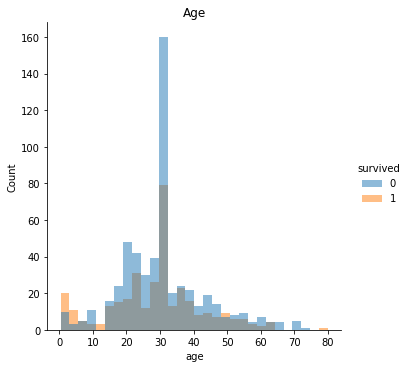

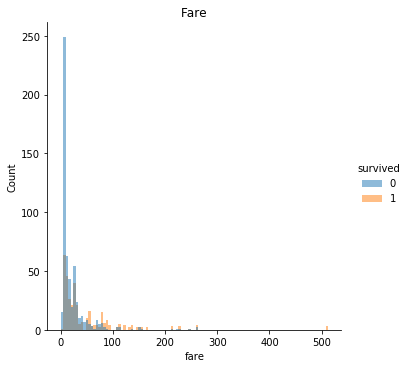

In [129]:
for ifeature, feature in enumerate(['age','fare']):
    sns.displot(data=df,x=feature,hue='survived',edgecolor=None)
    plt.title(feature.title())

* Lower class passengers had a lower probability of surviving
* Passengers with higher number of siblings and parents onboard were less likely to survive

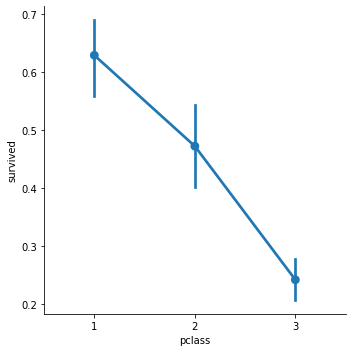

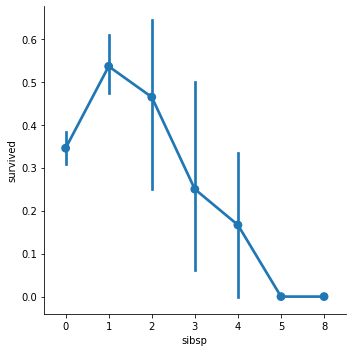

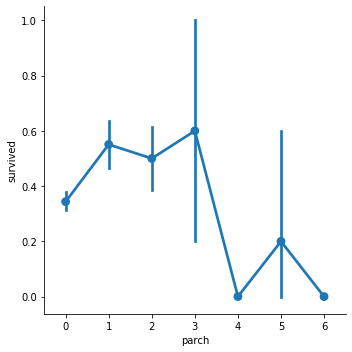

In [130]:
for ifeature, feature in enumerate(['pclass','sibsp','parch']):
    sns.catplot(x=feature,y='survived',data=df,kind='point')

The more people in your family, the less likely you are to survive

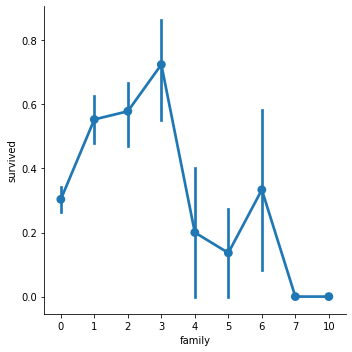

In [131]:
df['family'] = df['sibsp'] + df['parch'];

if 'sibsp' in df.columns:
    df.drop('sibsp',axis=1,inplace=True)
if 'parch' in df.columns:
    df.drop('parch',axis=1,inplace=True)
sns.catplot(x='family',y='survived', data=df,kind='point')

##### Explore categorical features

* Are the missing values for deck correlated with survival? Yes
* Do any of the other categorical features predict survival with high probability?

Looks like 67% (2/3rd) of the passengers for whom data about deck is not missing, survived. Since this gives us a very high predictive power, we should not just fill it with some mean value, but make a note of the fact that missingess is predictive os survival

In [132]:
df.groupby(~df['deck'].isna()).mean()

,survived,pclass,age,fare,adult_male,alone,family
deck,,,,,,,
False,0.299419,2.636628,28.072981,19.181079,0.636628,0.645349,0.911337
True,0.669951,1.197044,35.210361,76.341708,0.487685,0.458128,0.881773


In [133]:
df['deck_present'] = np.where(df['deck'].isna(), 0, 1)
df.head()

,survived,pclass,sex,age,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,family,deck_present
0,0,3,male,22.0,7.2500,S,Third,man,True,NaN,Southampton,no,False,1,0
1,1,1,female,38.0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,1,1
2,1,3,female,26.0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0,0
3,1,1,female,35.0,53.1000,S,First,woman,False,C,Southampton,yes,False,1,1
4,0,3,male,35.0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0,0


* Females were more likely to have survived
* People in the 1st and 2nd class were more likely to survive than people in the 3rd
* Like we see previously, people are more likely to survive if their deck info is present
* Embarking towns are not necessarily very predictive

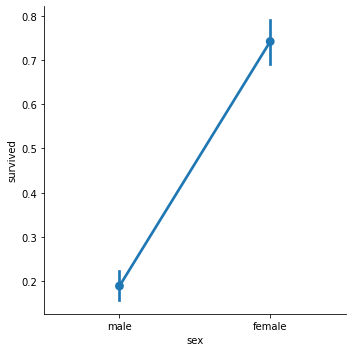

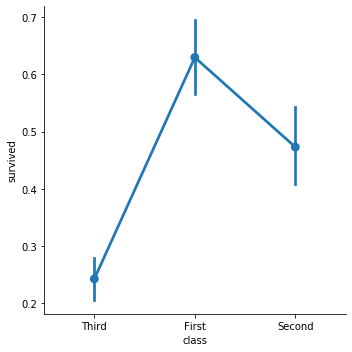

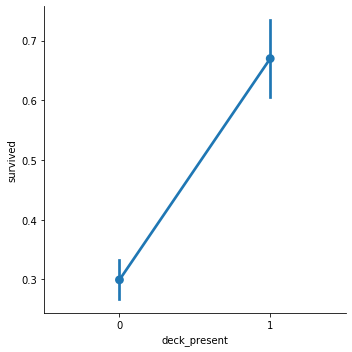

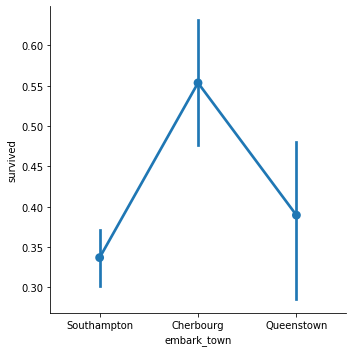

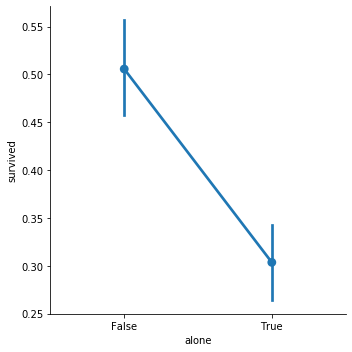

In [134]:
for ifeature, feature in enumerate(['sex','class','deck_present','embark_town','alone']):
    sns.catplot(x=feature, y='survived',data=df,kind='point')

If we want to look at multiple features in tandem, we can do that very easily as well

In [135]:
df.pivot_table('survived',index='sex',columns='embark_town',aggfunc='count')

embark_town,Cherbourg,Queenstown,Southampton
sex,,,
female,73,36,203
male,95,41,441


In [136]:
df.pivot_table('survived',index='sex',columns='deck_present',aggfunc='mean')

deck_present,0,1
sex,,
female,0.654378,0.938144
male,0.135881,0.424528


##### Cleaning data
* Make numeric values for sex and alone
* Drop features that might not be important

In [137]:
gender_dict = {'male':0, 'female':1}
df['sex']=df['sex'].map(gender_dict);
df['alone']=df['alone'].astype(int);
df.head()

,survived,pclass,sex,age,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,family,deck_present
0,0,3,0,22.0,7.2500,S,Third,man,True,NaN,Southampton,no,0,1,0
1,1,1,1,38.0,71.2833,C,First,woman,False,C,Cherbourg,yes,0,1,1
2,1,3,1,26.0,7.9250,S,Third,woman,False,NaN,Southampton,yes,1,0,0
3,1,1,1,35.0,53.1000,S,First,woman,False,C,Southampton,yes,0,1,1
4,0,3,0,35.0,8.0500,S,Third,man,True,NaN,Southampton,no,1,0,0


In [138]:
drop_cols = ['embarked','class','who','adult_male','deck','embark_town','alive']
for col in drop_cols:
    if col in df.columns:
        df.drop(col,axis=1,inplace=True)
df.head(5)

,survived,pclass,sex,age,fare,alone,family,deck_present
0,0,3,0,22.0,7.2500,0,1,0
1,1,1,1,38.0,71.2833,0,1,1
2,1,3,1,26.0,7.9250,1,0,0
3,1,1,1,35.0,53.1000,0,1,1
4,0,3,0,35.0,8.0500,1,0,0


In [139]:
X, y = df.drop('survived',axis=1), df['survived']

In [140]:
X.isna().sum()

pclass          0
sex             0
age             0
fare            0
alone           0
family          0
deck_present    0
dtype: int64

#### Chapter 5: End-to-end pipeline
Here, our goal is to build a model to predict whether a passenger aboard the Titanic survived or not. We'll take the following steps to build a robust model

* Split the data into train, test and validation sets to build the model
* First fit a model to all the training data to get a baseline estimate of performance 
    - Use `cross_val_score` to get cross validation scores
* Do hyperparameter tuning using validation data
    - `GridSearchCV` to search hyperparameters
* Evaluate on test data

In [141]:
''' Split data into train, valid and test
'''
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=2021)
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=2021);

print(round(len(y_train)/len(y),2))
print(round(len(y_test)/len(y),2))
print(round(len(y_valid)/len(y),2))

0.6
0.2
0.2


In [151]:
'''cross val score to get cross validation scores from within the training set
'''
rf = RandomForestClassifier();
scores_cv = cross_val_score(rf, X_train, y_train, cv=5)
print(scores_cv.mean())
print(scores_cv.std())

0.8425576519916144
0.021759159318531153


In [156]:
parameters = {
    'n_estimators':[5,50,100],
    'max_depth':[2,10,20,None]
}

cv_search = GridSearchCV(rf, parameters, cv=5)
cv_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [170]:
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

Unsurprisingly, as the maximum depth of the tree increases, accuracy increases. And also as the number of estimators increases, accuracy increases

In [167]:
results = cv_search.cv_results_;
for params, mean, std,  in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(f'For params: {params}, mean +/- STD: {mean:0.02f}, {std:0.02f}')

For params: {'max_depth': 2, 'n_estimators': 5}, mean +/- STD: 0.76, 0.03
For params: {'max_depth': 2, 'n_estimators': 50}, mean +/- STD: 0.77, 0.03
For params: {'max_depth': 2, 'n_estimators': 100}, mean +/- STD: 0.78, 0.01
For params: {'max_depth': 10, 'n_estimators': 5}, mean +/- STD: 0.81, 0.01
For params: {'max_depth': 10, 'n_estimators': 50}, mean +/- STD: 0.83, 0.03
For params: {'max_depth': 10, 'n_estimators': 100}, mean +/- STD: 0.84, 0.02
For params: {'max_depth': 20, 'n_estimators': 5}, mean +/- STD: 0.83, 0.05
For params: {'max_depth': 20, 'n_estimators': 50}, mean +/- STD: 0.84, 0.03
For params: {'max_depth': 20, 'n_estimators': 100}, mean +/- STD: 0.84, 0.03
For params: {'max_depth': None, 'n_estimators': 5}, mean +/- STD: 0.82, 0.03
For params: {'max_depth': None, 'n_estimators': 50}, mean +/- STD: 0.83, 0.03
For params: {'max_depth': None, 'n_estimators': 100}, mean +/- STD: 0.84, 0.02


I didn't know this before, but one can directly access the best params from the cv search results

In [174]:
cv_search.best_params_

{'max_depth': 20, 'n_estimators': 50}

Let's try 3 hyperparameter combinations and evaluate on the validation dataset:
* `max_depth`=20, `n_estimators`=50
* default: `max_depth`= None, `n_estimators`=100
* best in tutorial: `max_depth`=10, `n_estimators`=5

In [181]:
max_dep = [20,None,10,10]; n_est = [50,100,5,100]
rf_all=[]
acc, prec, rec = [np.zeros((len(max_dep),)) for _ in range(3)]
for i, (dep, est) in enumerate(zip(max_dep, n_est)):
    rf = RandomForestClassifier(max_depth=dep, n_estimators=est);
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_valid)
    acc[i], prec[i],rec[i] = accuracy_score(y_pred,y_valid), precision_score(y_pred,y_valid), recall_score(y_pred,y_valid)
    
    rf_all.append(rf)

In [182]:
df=pd.DataFrame();
df['max_depth']=max_dep; df['n_est']=n_est; df['accuracy']=acc; df['precision']=prec; df['recall']=rec
df

,max_depth,n_est,accuracy,precision,recall
0,20.0,50,0.797753,0.675325,0.825397
1,NaN,100,0.786517,0.662338,0.809524
2,10.0,5,0.786517,0.649351,0.819672
3,10.0,100,0.808989,0.688312,0.841270


Now, I choose the model with the best performance on the validation set and evaluate on the test dataset for a final evaluation

In [184]:
y_pred = rf[3].predict(X_test);

print(f'Accuracy: {accuracy_score(y_pred,y_test)}')
print(f'Precision: {precision_score(y_pred,y_test)}')
print(f'Recall: {recall_score(y_pred,y_test)}')


Accuracy: 0.7318435754189944
Precision: 0.6984126984126984
Recall: 0.6027397260273972


Reasonable performance, but I would have expected better